# Imitation Learning for MPC
## Credits: Andrea Tagliabue (atagliab@mit.edu), MIT ACL, 2023

# Objective
The objective of this script is to demonstrate how we can generate a neural network (NN) policy that reproduces the behavior of a Model Predictive Controller (MPC) on a pre-defined task, using Imitation Learning (IL). This procedure can be used, for example, to deploy MPC-like policies on computationally constrained hardware, as the inference speed of small NN is usually faster than the time required for solving an MPC problem online.

In the next steps, we will:
- Define a control task,
- Design an MPC to solve such a control task,
- Design a neural network policy and train it using MPC demonstrations,
- Evaluate the performance of the trained policy when the initial states are sampled from
	- the same distribution used for demonstration collection,
	- a previously unseen initial states distribution.

## Control task
The task at hand consists in stabilizing a cart to a zero position and velocity setpoint without violating the given position and velocity constraints. The cart moves along a straight line, with some non-zero initial position and velocity. The cart can be controlled by applying some external force (e.g. as produced by a fan mounted on the cart), that has to be smaller than a given threshold to avoid damage to the actuators.

- The state $x \in \mathcal{X}_c \subset \mathbb{R}^2$ of the cart is described by its position and velocity:

	$x_1$ = position,\
	$x_2$ = velocity \
	$\boldsymbol{x} = [x_1, x_2]^T$ \
  and it is such that $\mathcal{X}_c = \{x | |x_i| \leq $`x`$i$`_lim`$, i = 1, 2\}$.

- The control input $u \in \mathcal{U}_c \subset \mathbb{R}$ is a force acting along the direction of motion of the cart, taking values in:
 
	$\mathcal{U}_c = \{u | |u| \leq$ `u_lim`$\}$.

- The cart has unit mass, and its continuous-time model is given by:

  $\dot{x}_2 = u$ \
  $\dot{x}_1 = x_2$

- The initial state of the cart $\boldsymbol{x}_0 \in \mathcal{X}_0$ is assumed to be uniformly sampled from

	$\mathcal{X}_0 = \{ \boldsymbol{x} | x_i \leq$ `x`$i$`_ub`$, x_i \geq$ `x`$i$`_lb` $, i = 1, 2 \}$  (`init_state_bounds`).


In [1]:
import numpy as np
init_state_bounds = {"x1_ub": 6.0, "x1_lb": 4.0, "x2_ub": -2.0, "x2_lb": -4.0}
x_lim = np.array([10.0, 10.0])
u_lim = 20.0

# MPC design and evaluation
Here we design an MPC to solve the described control task. We use the discrete-time double integrator dynamics ($n_x = 2$, position and velocity, and $n_u = 1$, force), with state and actuation constraints and cost as defined in [here (Example 4)](https://arxiv.org/pdf/2109.11986.pdf).

In [2]:
# Create and MPC expert
mpc_params = {}

# Discretization time, [s]
mpc_params["Ts"] = 0.05

# Prediction horizone [steps]
mpc_params["T"] = 10

# Discrete time, double-integrator dynamics
# x_{k+1} = A x_{k} + B u_{k} 
mpc_params["A"] =  np.array([[1, mpc_params["Ts"]], [0, 1]])
mpc_params["B"] =  np.array([[0], [mpc_params["Ts"]]])

# Stage cost Q, R
mpc_params["Q"] =  np.eye(2)
mpc_params["R"] =  np.eye(1)

# Terminal cost
# Solution of Discrete Algebraic Riccati Equations
mpc_params["P"] = np.array([[35.6, 20.9], [20.9, 36.2]])

# Terminal affine state constraint 
# Xt_A x_{N} <= Xt_b
mpc_params["Xt_A"] = np.array([
    [-0.999, -0.050],
    [0.999, 0.050],
    [0.995, 0.100],
    [0.989, 0.148],
    [0.981, 0.196],
    [0.970, 0.243],
    [0.958, 0.287],
    [0.944, 0.330],
    [0.928, 0.371],
    [0.912, 0.410],
    [0.894, 0.447]])

mpc_params["Xt_b"] = np.array(
    [10.0, 10.0, 10.0, 10.0, 10.1, 10.2, 10.3, 10.4, 10.6, 10.8, 11.0]
).reshape((-1, 1))

# Affine state constraits
# Xc_A x <= Xc_b
mpc_params["Xc_A"] = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
mpc_params["Xc_b"] = np.array([[x_lim[0]], [x_lim[0]], [x_lim[1]], [x_lim[1]]])
mpc_params["x_lim"] = x_lim # store here for convenience

# Affine input constraints
# Uc_A u <= Uc_b
mpc_params["Uc_A"] = np.array([[1], [-1]])
mpc_params["Uc_b"] = np.array([[u_lim], [u_lim]])
mpc_params["u_lim"] = u_lim # store here for convenience

Now we generate the optimization problem associated with the given MPC parameters. 

In [3]:
import cvxpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class MpcExpert():
    def __init__(self, mpc_params, verbose = False):
        self.mpc_params = mpc_params
        self.solver_mpc_params = {
            'max_iter':500, 
            'eps_rel':1e-8, 
            'eps_abs':1e-8, 
            'verbose': verbose}

        self.make_optimization_problem(self.mpc_params)

    def make_optimization_problem(self, mpc_params):
        # Load mpc_params
        self.n = mpc_params["A"].shape[1] # State size
        self.m = mpc_params["B"].shape[1] # Actuation size

        self.T = mpc_params["T"]
        
        A = mpc_params["A"] # Discrete time A
        B = mpc_params["B"] # Discrete time B
        Q = mpc_params["Q"] # State stage cost
        R = mpc_params["R"] # Actuation stage cost
        P = mpc_params["P"] # State terminal cost

        Uc_A = mpc_params["Uc_A"]
        Uc_b = mpc_params["Uc_b"].squeeze()
        Xc_A = mpc_params["Xc_A"]
        Xc_b = mpc_params["Xc_b"].squeeze()

        Xt_A = mpc_params["Xt_A"]
        Xt_b = mpc_params["Xt_b"].squeeze()

        # Allocate solver variables            
        self.x = cvxpy.Variable((self.n, self.T+1))        # T+1 states
        self.u = cvxpy.Variable((self.m, self.T))          # T control inputs

        self.x0 = cvxpy.Parameter((self.n,))               # Initial state             

        # Define cost and constraints along the prediciton horizon
        cost = 0.0
        constr = []
        for t in range(self.T):
            # Define cost
            cost += cvxpy.quad_form(self.x[:,t], Q)    # State cost
            cost += cvxpy.quad_form(self.u[:,t], R)    # Actuation cost
            
            # Equality constraint encoding the system dynamics
            constr += [self.x[:,t+1] == A@self.x[:,t] + B@self.u[:,t]]

            # State constraints
            constr += [Xc_A@self.x[:,t] <= Xc_b]

            # Actuation constraints
            constr += [Uc_A@self.u[:,t] <= Uc_b]

        # Define terminal cost and set
        # Terminal cost
        cost += cvxpy.quad_form(self.x[:, self.T], P)

        # Terminal set (terminal state constraint)
        constr += [Xt_A@self.x[:, self.T] <= Xt_b]
        constr += [Xc_A@self.x[:, self.T] <= Xc_b]

        # Initial state constraint
        constr += [self.x[:, 0] == self.x0]

        # sums problem objectives and concatenates constraints.
        self.problem = cvxpy.Problem(cvxpy.Minimize(cost), constr)
    
    def compute_action(self, x0, verbose = False):
        """
            Solves optimization problem given an initial state. 
            Inputs: 
                x0          :   initial state
            Output:
                u           :  first command computed in the plannig horizon, u_0 
        """
        assert x0.shape == (self.n, ), f"Wrong shape for x0: {x0.shape}"
        
        # Update the initial state constraint
        self.x0.value = x0

        # solve problem
        # https://www.cvxpy.org/tutorial/advanced/index.html#setting-solver-options
        self.problem.solve(solver=cvxpy.OSQP, **self.solver_mpc_params)

        # evaluate solution
        assert self.problem.status not in ["infeasible", "unbounded"], f"Problem is {self.problem.status}"
            
        # Return the first control input in the planning horizon
        u_cmd = self.u[:,0].value
        return u_cmd

    def visualize_latest_solution(self):
        """
            Plots the state and the control inputs 
            computed in the planning horizon. 
            Please call this method after calling "solve(x0)". 
        """ 
        plot_state_actions(states = self.x.value.T, 
            actions = self.u.value.T, 
            sampling_time=self.mpc_params["Ts"], 
            u_lim = self.mpc_params["u_lim"])
        plot_phase_diagram(states = self.x.value.T, mpc_params = self.mpc_params)

def plot_state_actions(states, actions, sampling_time, u_lim = None):
    """
        Plots the state and the control inputs 
        input: 
            states:  np.array of size (num_timesteps, state_size)
            actions: np.array of size (num_timesteps, action_size)
            sampling_time: sampling time of states and actions
            u_lim: actuation constraints
    """ 
    assert states.shape[0] == actions.shape[0] + 1
    state_size = states.shape[1]
    action_size = actions.shape[1]
    num_timesteps = states.shape[0]
    
    fig, axs = plt.subplots(state_size + action_size, 1, figsize=(6,12))
    
    axs[0].set_title("States and Command vs Time")

    total_time = sampling_time*num_timesteps
    t = np.linspace(start = 0, stop = total_time, num = num_timesteps)
    
    # Plot states
    [axs[i].plot(t, states[:, i], label=f"x_{i+1}") for i in range(state_size)]

    # Plot control inputs
    [axs[i + state_size].plot(t[:-1], actions[:, i], label=f"u_{i+1}") for i in range(action_size)]
    
    # Control input limits
    if u_lim is not None: 
        axs[state_size].axhline(y = u_lim, color = 'r', linestyle = '--', label = "u_max")
        axs[state_size].axhline(y = -u_lim, color = 'r', linestyle = '--', label = "u_min")

    # Plot legends and x-y labels
    [axs[i].legend() for i in range(state_size + action_size)]
    [axs[i].set_xlabel("Time (s)") for i in range(state_size + action_size)]
    ylabels = ['x1, pos (m)', 'x2, vel (m/s)', 'u, force (N)']
    [axs[i].set_ylabel(ylabels[i]) for i in range(state_size + action_size)]

def draw_aabb_on_axs(axs, x1_ub, x1_lb, x2_ub, x2_lb, color, label):
    """
        Draws a 2D axis-aligned bounding box given 
        axs:                figure axes, 
        x1_ub, ..., x2_lb:  upper and lower bounds
        color: a desired color 
        label: label for the plot
    """
    axs.add_patch(Rectangle((x1_lb, x2_lb), 
                x1_ub - x1_lb, 
                x2_ub - x2_lb, 
                alpha = 0.2, 
                color = color, 
                label = label))
    return axs

def plot_phase_diagram(states, mpc_params, init_state_bounds = None, new_figure = True): 
    """
        Plots state trajectory on the phase diagram: 
        states: np.array, of (number_of_states, state_size)
        mpc_params: 
            mpc parameters containing state constraints ("x_lim")
        init_state_bounds: bounds to plot the intial state region
        new_figure: plots on a new figure, 
                    else will get current axis (to add multiple trajectories on sampe plot). 
    """
    assert states.shape[1] == 2, "Phase diagram only available for two dimensional states!"
    assert "x_lim" in mpc_params.keys()

    if new_figure: 
        fig, axs = plt.subplots(1, 1, figsize = (5, 5))

        # State trajectory
        axs.set_title("Phase diagram")
        axs.plot(states[:, 0], states[:, 1], label = 'trajectory')
        axs.set_xlabel('x1 (m)')
        axs.set_ylabel('x2 (m/s)')

        # Initial/Terminal state
        X_GOAL = np.array([0, 0])
        axs.plot(states[0,0], states[0, 1], marker='o', label='initial state')
        axs.plot(X_GOAL[0], X_GOAL[1], marker='x', color= 'r', label='goal state')

        # State constraints
        axs = draw_aabb_on_axs(
            axs = axs, 
            x1_ub = mpc_params["x_lim"][0], 
            x1_lb = -mpc_params["x_lim"][0], 
            x2_ub = mpc_params["x_lim"][1], 
            x2_lb = -mpc_params["x_lim"][1], 
            color = 'g', 
            label =  "state constraints")
        axs.legend()

        if init_state_bounds is not None:
            axs = draw_aabb_on_axs(
                axs = axs, 
                x1_ub = init_state_bounds["x1_ub"], 
                x1_lb = init_state_bounds["x1_lb"], 
                x2_ub = init_state_bounds["x2_ub"], 
                x2_lb = init_state_bounds["x2_lb"], 
                color = 'b', 
                label =  "init states region")
        axs.legend()

    else:
        # Update existing figure adding trajectory and init state
        axs = plt.gca()
        axs.plot(states[:, 0], states[:, 1], label = 'trajectory')
        axs.plot(states[0,0], states[0, 1], marker='o', label='initial state')

# Create the MPC expert. 
mpc_expert = MpcExpert(mpc_params=mpc_params)

Initial state: [2. 2.], MPC action: [-5.32816261]. 


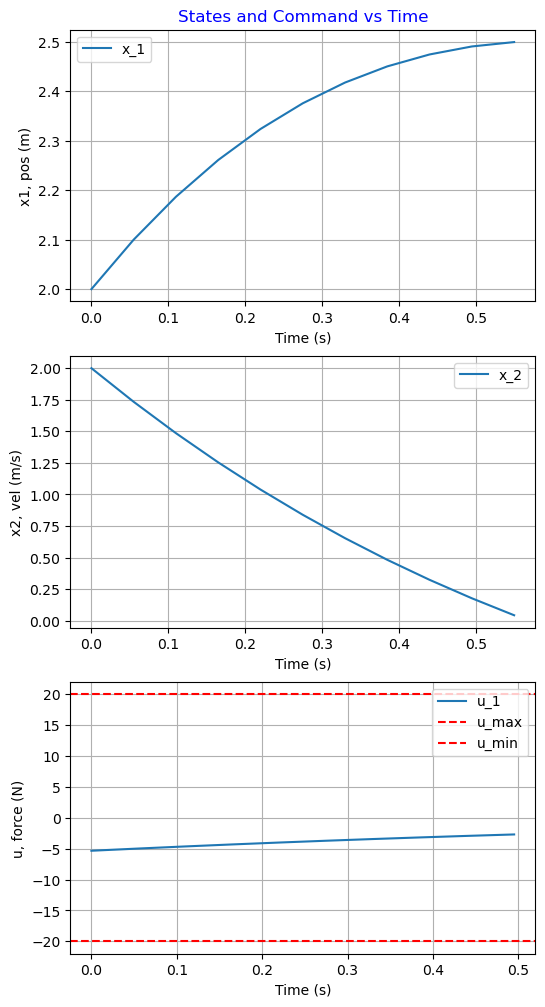

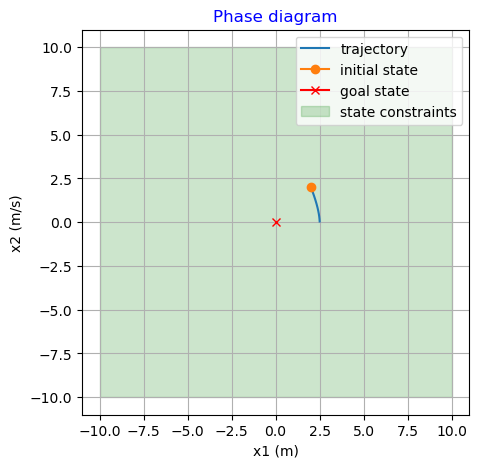

In [4]:
# Let's try the MPC starting from the following initial state: 
x0 = np.array([2.0, 2.0])
u0 = mpc_expert.compute_action(x0, verbose = False)
print(f"Initial state: {x0}, MPC action: {u0}. ")

# Let's visualizae the latest solution found
mpc_expert.visualize_latest_solution()

# Student Policy
Here we define the student policy that we aim to train and that will reproduce the input/output of MPC. 


In [5]:
import torch 

class NnStudent(torch.nn.Module):
    def __init__(self, input_size, output_size):
        # Define simple neural network policy
        # Two hidden layers, 32 neurons per layer
        # Fully connected output
        # ReLu activation function
        super(NnStudent, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = 32

        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size, bias=True),
            torch.nn.ReLU()
        )
        self.output_layer = torch.nn.Linear(in_features=self.hidden_size, out_features=self.output_size, bias=True)

    def forward(self, x):
        """
            Given a state x, predics an action u
        """
        x_hidden = self.hidden_layers(x)
        u = self.output_layer(x_hidden)
        return u

    def compute_action(self, x):
        """
           This is a wrapper for the previous 'forward' 
           method that automatically converts 
           the input/outpurs in numpy array instead of
           torch tensors. 
        """
        assert x.shape == (self.input_size, )
        u = self.forward(torch.Tensor(x)).detach().numpy()
        return u

# Create neural network policy with randomly initialized weights
student_policy = NnStudent(input_size = mpc_params["A"].shape[1], output_size = mpc_params["B"].shape[1])
print(student_policy)

NnStudent(
  (hidden_layers): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


Let's check the output of the policy for the same initial state used in the MPC test:

In [6]:
u0_untrained_policy = student_policy.compute_action(x0)
print(f"Initial state: {x0}, (untrained) neural network policy output: {u0_untrained_policy}.")

Initial state: [2. 2.], (untrained) neural network policy output: [0.4284619].


# Simulation environment 
Here we define the simulation environment that we use to collect demonstrations and evaluate the MPC and the trained policy. 

In [7]:
# Define a simulation environment to collect demonstrations. 
sim_params = {}
sim_params["mpc_params"] = mpc_params

# We assume that the simulation runs at 10 Hz, 
sim_params["Ts"] = 0.1     # Sampling time [s]

# and includes an higher-fidelity model 
# (e.g. with some drag)
sim_params["mass"] = 1.0  # [Kg]   
sim_params["drag"] = 0.1  # [Ns/m]


# The task we intendo to learn is to reach the terminal (goal) state, that in our case is the origin, starting 
# from an initial state sampled from the following initial state distribution, assumed uniform: 
sim_params["init_state_bounds"] = init_state_bounds
sim_params["max_time"] = 12.0     # Maximum simulation time in [s]

class SimulationEnvironment(): 
    def __init__(self, params):
        self.params = params
        self.reset()
    
    def step(self, u):
        """
        Inputs: 
            u: control input at time t
        Outputs: 
            x_next: next state, at time t + sim_params["Ts"], 
        """
        assert u.shape == (self.params["mpc_params"]["B"].shape[1], )
        
        # Current state
        p_curr, v_curr = self.current_state[0], self.current_state[1]

        # mass * acceleration = u - drag*velocity
        f_curr = u - self.params["drag"]*v_curr   # Current forces acting on the system
        a_curr = f_curr/self.params["mass"]     # Current acceleration
        
        # Forward euler discretization of the continuous time cart dynamics w/ friction:
        # ( = linear motion under constant acceleration) 
        v_next = v_curr + self.params["Ts"]*a_curr
        p_next = p_curr + v_curr*self.params["Ts"] + 0.5*a_curr*(self.params["Ts"]**2)

        next_state = np.array([p_next, v_next]).squeeze()

        self.current_state = next_state
        self.current_time += self.params["Ts"]

        done = False
        if self.current_time > self.params["max_time"]:
            done = True

        return next_state, done

    def reset(self):
        """
            Resets the initial state of the simulation
            by uniformly sampling it from 
            an initial state distribution
        """
        init_state_param = self.params["init_state_bounds"]
        init_state_lb = np.array([init_state_param["x1_lb"], init_state_param["x2_lb"]])
        init_state_ub = np.array([init_state_param["x1_ub"], init_state_param["x2_ub"]])
        init_state = np.random.uniform(low = init_state_lb, high = init_state_ub)
        
        self.current_state = init_state
        
        self.current_time = 0.0
        
        return init_state

env = SimulationEnvironment(params = sim_params)

## MPC performance evaluation
We start by evaluating the performance of MPC in the simulation environment, applying its control inputs in a receding horizon way. This procedure is called "rollout" and is equivalent to collecting one demonstration.

In [8]:
import time

def rollout(env, agent, show_inference_time = False):
    """
        Computes a state-action trajectory using 
        agent and the given enviroment.
        This method can be used for demonstration collection
        or for evaluation of the policy/MPC. 
    """
    state_hist = []
    act_hist = []
    elapsed_time_hist = []
    
    done = False
    x = env.reset()
    state_hist.append(x)
    while not done:
        
        # Compute action
        t = time.time()
        u = agent.compute_action(x)
        elapsed = time.time() - t
        
        # Simulate dynamics
        x, done = env.step(u)
        
        # Log
        act_hist.append(u)
        state_hist.append(x)
        elapsed_time_hist.append(elapsed)

    if show_inference_time:
        print(f"Time to compute action: mean: {np.mean(elapsed_time_hist)*1000:.3} [ms], sd: {np.std(elapsed_time_hist)*1000:.3} [ms].")

    return np.array(state_hist), np.array(act_hist)

Time to compute action: mean: 2.08 [ms], sd: 0.556 [ms].
Time to compute action: mean: 1.84 [ms], sd: 0.0633 [ms].
Time to compute action: mean: 1.86 [ms], sd: 0.0839 [ms].
Time to compute action: mean: 1.85 [ms], sd: 0.0871 [ms].
Time to compute action: mean: 1.85 [ms], sd: 0.102 [ms].
Time to compute action: mean: 1.84 [ms], sd: 0.0738 [ms].
Time to compute action: mean: 1.85 [ms], sd: 0.0726 [ms].
Time to compute action: mean: 1.83 [ms], sd: 0.0675 [ms].
Time to compute action: mean: 1.82 [ms], sd: 0.0651 [ms].
Time to compute action: mean: 1.83 [ms], sd: 0.0715 [ms].


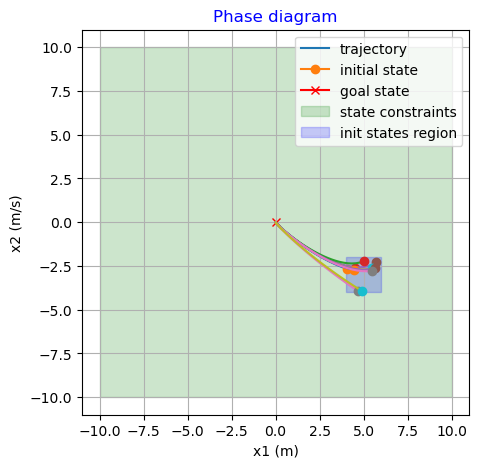

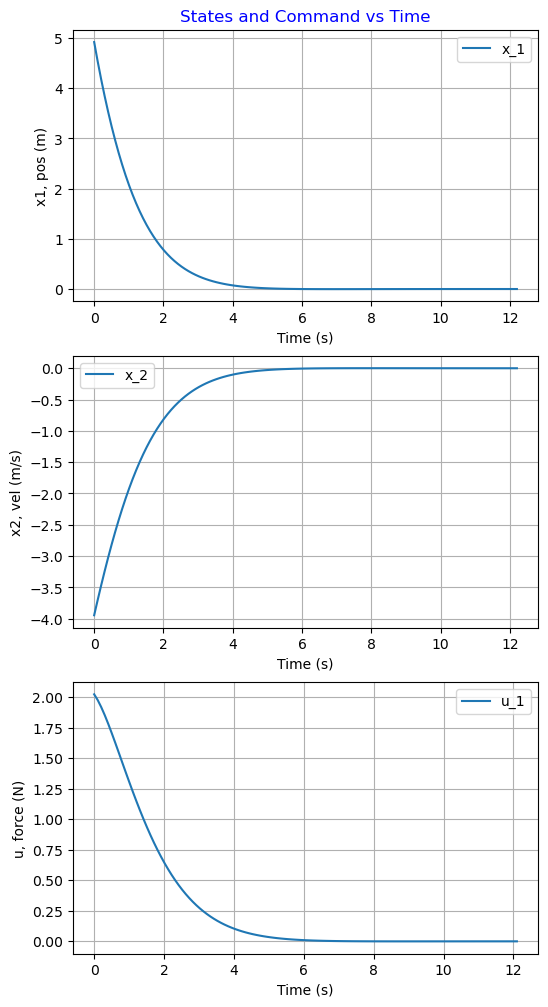

In [9]:
N_tests = 10
for i in range(N_tests):
    states, actions = rollout(env = env, agent = mpc_expert, show_inference_time = True)
    plot_phase_diagram(states = states, 
        mpc_params=mpc_params, 
        init_state_bounds=sim_params["init_state_bounds"], 
        new_figure=bool(i==0))

plot_state_actions(states, actions, sim_params["Ts"])

The MPC can successfully drive the system to the origin.

## Untrained Policy performance evaluation
Let's have a look at the response of the untrained policy: 


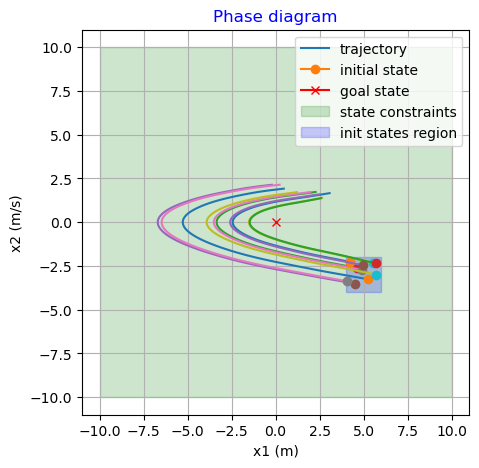

In [11]:
for i in range(N_tests):
    states, actions = rollout(env = env, agent = student_policy, show_inference_time = False)
    plot_phase_diagram(states = states, 
        mpc_params=mpc_params, 
        init_state_bounds=sim_params["init_state_bounds"], 
        new_figure=bool(i==0))

Unsurprisingly, the untrained policy cannot stabilize the system to the origin. 

# Policy training using Imitation Learning (Behavior Cloning)
We now collect multiple MPC demonstrations, starting from different initial states as defined in the state distribution in the simulated environment, and we store state and action pairs in a dataset. This technique is called Behavior (or Behavioral) cloning, as we collect demonstrations by only querying the expert.

In [12]:
il_params  = {}
# Number of demonstrations collected
il_params["N_demonstrations"] = 10

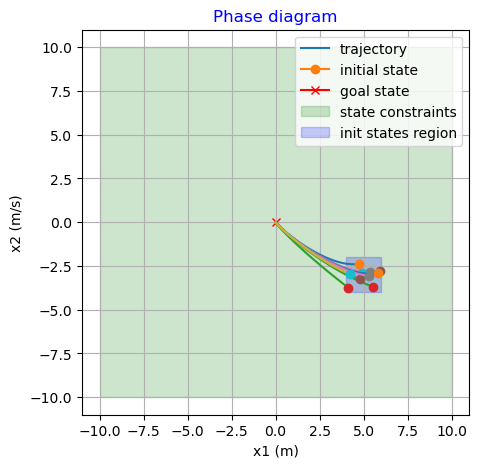

In [13]:
import pandas

# Collect N_demonstrations demonstrations starting from random initial states,
# sampled inside the initial state distribution.  
# We use behavior cloning, e.g. we collect demonstrations by only querying the expert. 
# We store the states and actions pairs in a pandas dataframe 
demonstrations = pandas.DataFrame() # This will be a table with columns: x1, x2, u
for i in range(il_params["N_demonstrations"]): 
    
    # Rollout & store
    states, actions = rollout(env = env, agent = mpc_expert)
    curr_demonstration = pandas.DataFrame({'x1': states[:-1, 0], 'x2': states[:-1, 1], 'u': actions.squeeze()})
    demonstrations = pandas.concat([demonstrations, curr_demonstration], ignore_index=True)
    
    # Visualize
    plot_phase_diagram(states = states, 
        mpc_params = mpc_params, 
        init_state_bounds = sim_params["init_state_bounds"], 
        new_figure = bool(i == 0))

In [14]:
# This is a table with state, action pairs
print(demonstrations)

            x1        x2         u
0     4.749032 -2.377799 -0.485925
1     4.510012 -2.402613 -0.214816
2     4.269878 -2.400069  0.010654
3     4.031124 -2.375003  0.196359
4     3.795793 -2.331617  0.347515
...        ...       ...       ...
1205 -0.000070  0.000072 -0.000056
1206 -0.000063  0.000066 -0.000052
1207 -0.000057  0.000060 -0.000048
1208 -0.000051  0.000055 -0.000044
1209 -0.000046  0.000050 -0.000041

[1210 rows x 3 columns]


We are now ready to train the policy. We start by defining some utility functions to load the dataset, split it in train and validation, and perform the supervised regression. 

In [15]:
training_params = {}
training_params["batch_size"] = 32
training_params["train_valid_split"] = 0.7 # 70% data for training, other for validation

training_params["n_epochs"] = 200 # Max # training epochs 
training_params["patience"] = 10  # Terminates training if best validation loss does not improve within 'patience' epochs (often avoids overfitting)
training_params["learning_rate"] = 0.001

In [16]:
class DemonstrationsDataset(torch.utils.data.Dataset):
 
  def __init__(self, pandas_dataset):
    self.pandas_dataset = pandas_dataset
 
    self.states = torch.tensor([pandas_dataset['x1'], pandas_dataset['x2']], dtype=torch.float32)
    self.actions = torch.tensor(pandas_dataset['u'], dtype=torch.float32).reshape((-1, 1))
 
  def __len__(self):
    return len(self.actions)
   
  def __getitem__(self,idx):
    return {"obs": self.states[:, idx], "acts":  self.actions[idx]}

demonstration_dataset = DemonstrationsDataset(demonstrations)

In [17]:
import copy 
import torch.utils.data as th_data

def split_data_in_train_val(dataset, seed = 0, train_split = 0.7, batch_size = 32):
    """
        Splits the dataset in training and validation set. 
    """
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
                                    copy.deepcopy(dataset), 
                                    [train_size, test_size], 
                                    generator=torch.Generator().manual_seed(seed))
    
    train_loader = th_data.DataLoader(train_dataset,
                                    batch_size=batch_size,
                                    drop_last=True,
                                    shuffle=True,
                                    )
    val_loader = th_data.DataLoader(val_dataset,
                                batch_size=batch_size,
                                drop_last=True,
                                shuffle=True,
                                )

    return train_loader, val_loader
train_loader, val_loader = split_data_in_train_val(demonstration_dataset, batch_size=training_params["batch_size"], train_split=training_params["train_valid_split"])

In [18]:
# Credits: https://github.com/Bjarten/early-stopping-pytorch (MIT License, Copyright (c) 2018 Bjarte Mehus Sunde)
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [19]:
def train_model(train_loader, valid_loader, patience, n_epochs, model, optimizer, loss_f): 
    """
        Train model & returns number of epochs used for trainig,
        which may vary due to early termination.
    """
    assert len(train_loader) > 0, "Training Dataloader is empty!"
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    def  compute_loss(obs, acts, model, loss_f): 
        obs = torch.as_tensor(obs).detach()
        pred_acts = model.forward(obs) # return: action 
        acts = torch.as_tensor(acts).detach()
        loss = loss_f(pred_acts.float(), acts.float())
        return loss
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch_num, train_batch in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # calculate fw pass and the loss
            loss = compute_loss(train_batch["obs"], train_batch["acts"], model, loss_f)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for valid_batch in valid_loader:

            # calculate fw pass and the loss
            val_loss = compute_loss(valid_batch["obs"], valid_batch["acts"], model, loss_f)
            # record validation loss
            valid_losses.append(val_loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return epoch

In [20]:
# We are finally ready to train the policy: 
optimizer = torch.optim.Adam(student_policy.parameters(), lr = training_params["learning_rate"]) # We use the Adam optimizer
# Loss function: mean squared error
loss_f = torch.nn.MSELoss(reduction='mean') # Mean squared error loss

train_batch = train_model(
    train_loader = train_loader, 
    valid_loader = val_loader, 
    patience=training_params["patience"], 
    model = student_policy, 
    optimizer = optimizer, 
    loss_f = loss_f, 
    n_epochs = training_params["n_epochs"])

[  1/200] train_loss: 0.07978 valid_loss: 0.08441
[  2/200] train_loss: 0.05126 valid_loss: 0.06966
[  3/200] train_loss: 0.04331 valid_loss: 0.06371
[  4/200] train_loss: 0.03604 valid_loss: 0.04915
[  5/200] train_loss: 0.02771 valid_loss: 0.03665
[  6/200] train_loss: 0.02059 valid_loss: 0.03383
[  7/200] train_loss: 0.01541 valid_loss: 0.02681
[  8/200] train_loss: 0.01126 valid_loss: 0.02151
[  9/200] train_loss: 0.00850 valid_loss: 0.01662
[ 10/200] train_loss: 0.00789 valid_loss: 0.01316
[ 11/200] train_loss: 0.00648 valid_loss: 0.01269
[ 12/200] train_loss: 0.00559 valid_loss: 0.01059
[ 13/200] train_loss: 0.00449 valid_loss: 0.00917
[ 14/200] train_loss: 0.00387 valid_loss: 0.00795
[ 15/200] train_loss: 0.00304 valid_loss: 0.00735
[ 16/200] train_loss: 0.00303 valid_loss: 0.00579
[ 17/200] train_loss: 0.00275 valid_loss: 0.00511
[ 18/200] train_loss: 0.00246 valid_loss: 0.00440
[ 19/200] train_loss: 0.00253 valid_loss: 0.00531
EarlyStopping counter: 1 out of 10
[ 20/200] train

# Policy Performance Evaluation
Let's start by evaluating the performance of the trained policy when the initial state is sampled from the same intial state distribution used to collect demonstrations: 

Time to compute action: mean: 0.113 [ms], sd: 0.086 [ms].
Time to compute action: mean: 0.094 [ms], sd: 0.0219 [ms].
Time to compute action: mean: 0.0819 [ms], sd: 0.0208 [ms].
Time to compute action: mean: 0.0778 [ms], sd: 0.0105 [ms].
Time to compute action: mean: 0.0732 [ms], sd: 0.00793 [ms].
Time to compute action: mean: 0.0739 [ms], sd: 0.014 [ms].
Time to compute action: mean: 0.0768 [ms], sd: 0.0163 [ms].
Time to compute action: mean: 0.0745 [ms], sd: 0.00521 [ms].
Time to compute action: mean: 0.0754 [ms], sd: 0.00802 [ms].
Time to compute action: mean: 0.0746 [ms], sd: 0.0116 [ms].


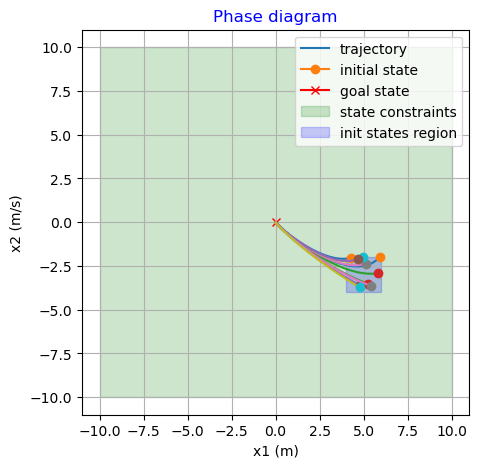

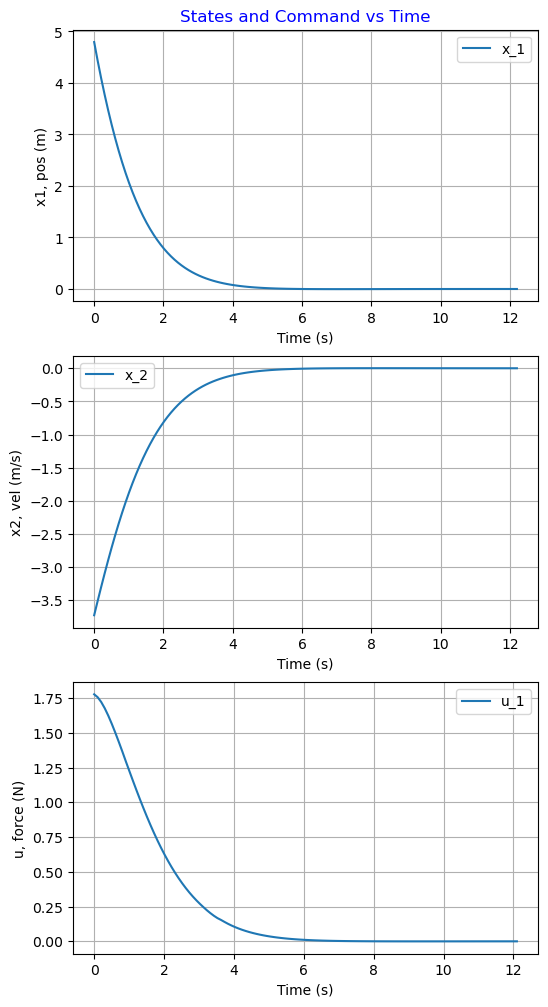

In [21]:
student_policy.eval()
N_evals = 10
for i in range(N_evals): 
    states, actions = rollout(env = env, agent = student_policy, show_inference_time = True)
    plot_phase_diagram(states = states, 
        mpc_params=mpc_params, 
        init_state_bounds=sim_params["init_state_bounds"], 
        new_figure=bool(i==0))

# Stats, actions vs time for the last trajectory
plot_state_actions(states, actions, sim_params["Ts"])

### Result: 
The policy has learned to reproduce the response of the exepert when starting from the same initial state distribution, and the time to compute a new action is about one order of magnitue smaller.

## Generalization Study: 
Will the policy work if we start from an initial state sampled outside the initial state distribution used for training? Let's find out by defining a new initial state distribution and evaluating the policy 10 times. 

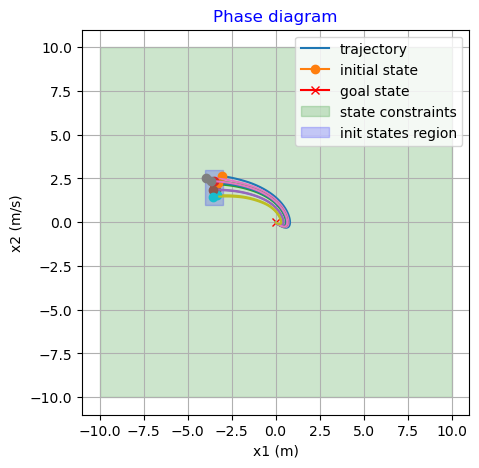

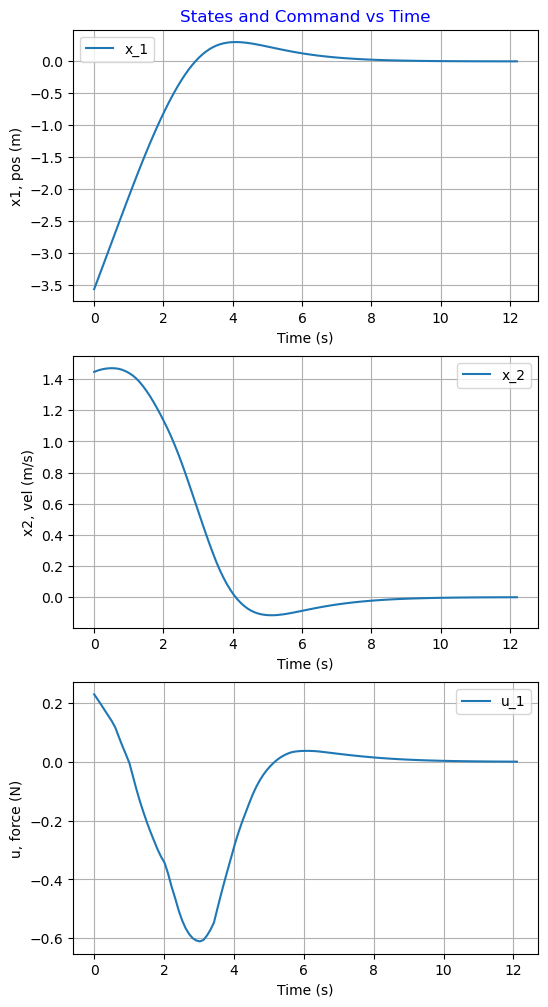

In [22]:
# Let's define new initial state bounds: 
init_state_bounds = {"x1_ub": -3.0, "x1_lb":-4.0, "x2_lb":1.0, "x2_ub":3.0}

sim_params["init_state_bounds"]= init_state_bounds
# Let's create e new simulator: 
previously_unseen_env = SimulationEnvironment(params = sim_params)
student_policy.eval()

N_eval = 10
for i in range(N_eval): 
    states, actions = rollout(env = previously_unseen_env, agent = student_policy, show_inference_time = False)
    plot_phase_diagram(states = states, 
        mpc_params=mpc_params, 
        init_state_bounds=sim_params["init_state_bounds"],
        new_figure=bool(i==0))

plot_state_actions(states, actions, sim_params["Ts"])